In [1]:
import os, time, h5py, platform, json, sys, matplotlib, glob
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
sys.path.append(r"C:\Users\Gerwin\Documents\Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm, trange
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from termcolor import cprint
from glob import glob
from Common import common, kfit
import matplotlib.gridspec as gridspec
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

try:
    sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch\experiment")
    from data_cache import dataCacheProxy
except:
    pass

**Relevant references**
* Experiment: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.79.045406
* Numerics: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046602

## Set up the RF-field profile

In [2]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import elementary_charge as q_e, electron_mass as m_e

settings_file = r"/Users/gkoolstra/Desktop"
settings_file += r"/With L3 etch - just trap/settings.json"
fs = FullSolver(settings_file)

# Set up the RF electric field path and load it into memory
fs.resonator_constants['f0'] = 6.405E9
fs.resonator_constants['Q'] = 1.3E4
fs.resonator_constants['Z0'] = 90.0

def Ex(xi, yi):
    return 1e1 * np.ones(len(xi))

def Ey(xi, yi):
    return 3E5 * np.exp(-yi ** 2 / (2 * (0.5E-6) ** 2))

fs.Ex = Ex
fs.Ey = Ey

kappa_tot = fs.resonator_constants['f0'] / fs.resonator_constants['Q']

In [3]:
fs.include_screening

1

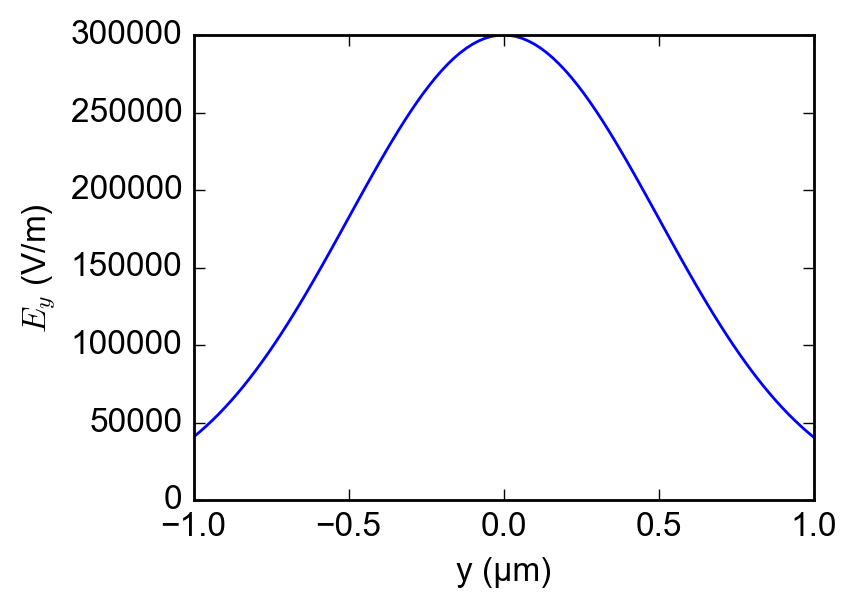

In [4]:
yplot = np.linspace(-1E-6, 1E-6, 101)

plt.figure(figsize=(4.,3.))
common.configure_axes(12)
plt.plot(yplot * 1E6, Ey(np.zeros(len(yplot)), yplot))
plt.xlabel("y (%sm)"%chr(956))
plt.ylabel("$E_y$ (V/m)")

## Set up initial electron positions and potential shape 

In [5]:
initial_guesses = [{"N" : 1, "init_guess" : np.array([0, 0]), 
                    "adaptive_guess" : True}, 
                   {"N" : 2, "init_guess" : np.array([0.0, 3.34106244e-07, 0.0, -3.34106244e-07]), 
                    "adaptive_guess" : True},
                   {"N" : 3, "init_guess" : np.array([1.88584116e-11, 4.83470160e-07, -2.48886397e-11, 
                                                      -4.83471271e-07, 1.75130320e-11, 7.89948645e-12]), 
                    "adaptive_guess" : True}, 
                   {"N" : 4, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07]), 
                    "adaptive_guess" : True}, 
                   {"N" : 5, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07, 
                                                      0, 0]), 
                    "adaptive_guess" : True}]

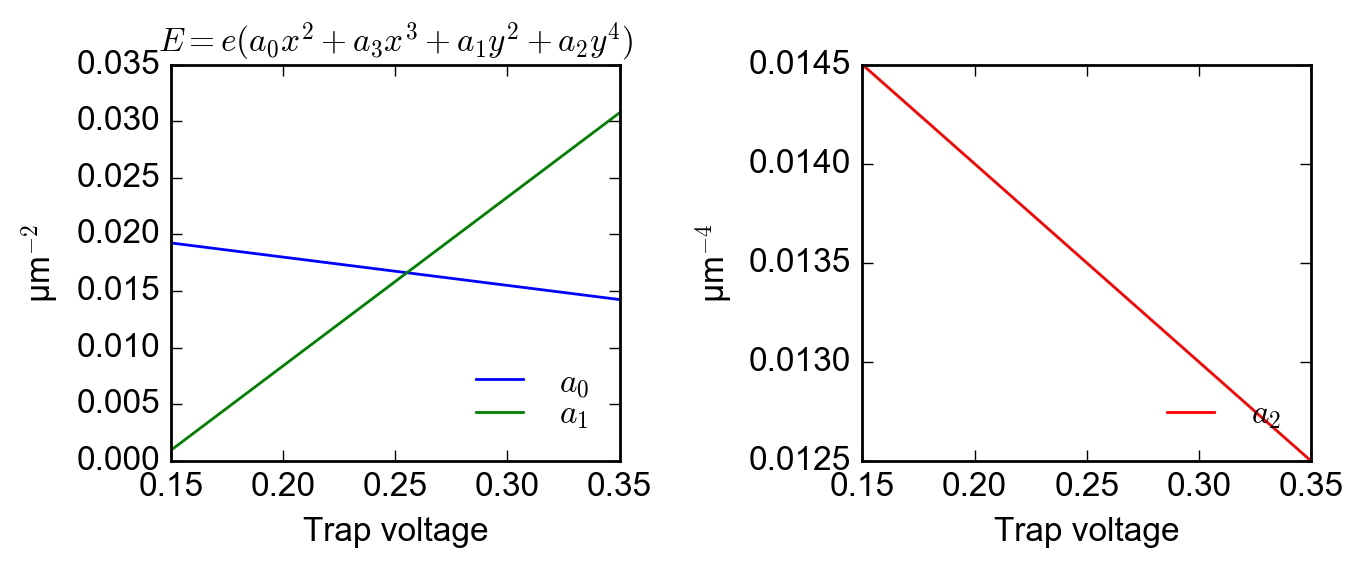

In [14]:
dfdV = 90E9
V_crossing = 0.174

V0 = V_crossing - fs.resonator_constants['f0'] / (2 * dfdV)

Vtrap = np.linspace(0.15, 0.35, 101)
Vrg = np.linspace(-0.415, -0.426, len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))

# a_0s = 0.021E12 - 0.02E12 * (Vtrap - V0)
# a_1s = m_e / (2 * q_e) * 8 * np.pi ** 2 * dfdV * fs.resonator_constants['f0'] * (Vtrap - V0)

def a_0s(Vtrap):
    return 1E12 * (0.023 - 0.025 * Vtrap) #1E12 * (0.032 - 0.006 - 0.020 * Vtrap)

def a_1s(Vtrap):
    return 1E12 * (-0.0214 + 0.149 * Vtrap)

def a_2s(Vtrap):
    return 1E24 * (0.016 - 0.01 * Vtrap)

def a_3s(Vtrap):
    return 0 * 0.8 * -1E16

contain_xs = 0 * 0.001E24 * np.ones(len(Vtrap))

fig = plt.figure(figsize=(7.,3.))
common.configure_axes(12)
plt.subplot(121)
plt.title("$E = e (a_0 x^2 + a_3 x^3 + a_1 y^2 + a_2 y^4)$", size=12)
plt.plot(Vtrap, a_0s(Vtrap) * 1E-12, label="$a_0$")
plt.plot(Vtrap, a_1s(Vtrap) * 1E-12, label='$a_1$')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-2}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

plt.subplot(122)
plt.plot(Vtrap, a_2s(Vtrap) * 1E-24, label='$a_2$', color='r')
# plt.plot(Vtrap, a_3s * 1E-24, label='$a_3$', color='c')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-4}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

fig.tight_layout()

## Load experimental results for comparison 

In [15]:
datapath = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Figure 3"
filename = r"exported_traces_mag_n_phase.h5"

with h5py.File(os.path.join(datapath, filename), 'r') as hf:
    Vtrap_experiment = hf['Vtrap'][:]
    Vrg_experiment = hf['Vrg'][:]
    
    mags_experiment_0 = hf['mags_averaged_normalized_Ne_0'][:]
    mags_experiment_1 = hf['mags_averaged_normalized_Ne_1'][:]
    mags_experiment_2 = hf['mags_averaged_normalized_Ne_2'][:]
    mags_experiment_3 = hf['mags_averaged_normalized_Ne_3'][:]
    mags_experiment_4 = hf['mags_averaged_normalized_Ne_4'][:]
    
    phases_experiment_0 = hf['phase_averaged_Ne_0'][:]
    phases_experiment_1 = hf['phase_averaged_Ne_1'][:]
    phases_experiment_2 = hf['phase_averaged_Ne_2'][:]
    phases_experiment_3 = hf['phase_averaged_Ne_3'][:]
    phases_experiment_4 = hf['phase_averaged_Ne_4'][:]
    
phase_offsets = [0, -0.5, -1, -1.5]

## Run minimization and simulate cavity response

  1%|          | 1/101 [00:00<00:12,  8.27it/s]

N =  1


  0%|          | 0/101 [00:00<?, ?it/s]/Users/gkoolstra/Documents/Code/TrapAnalysis/solve_eom.py:266: RuntimeWarning: divide by zero encountered in true_divide
  tij = np.arctan(YiYj / XiXj)
  1%|          | 1/101 [00:00<00:10,  9.33it/s]

N =  2


100%|██████████| 101/101 [00:09<00:00, 11.72it/s]
/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:200: RuntimeWarning: divide by zero encountered in log10
  1%|          | 1/101 [00:00<00:14,  6.86it/s]

N =  3


  1%|          | 1/101 [00:00<00:15,  6.35it/s]

N =  4


  1%|          | 1/101 [00:00<00:18,  5.55it/s]

N =  5


100%|██████████| 101/101 [00:00<00:00, 43271.16it/s]


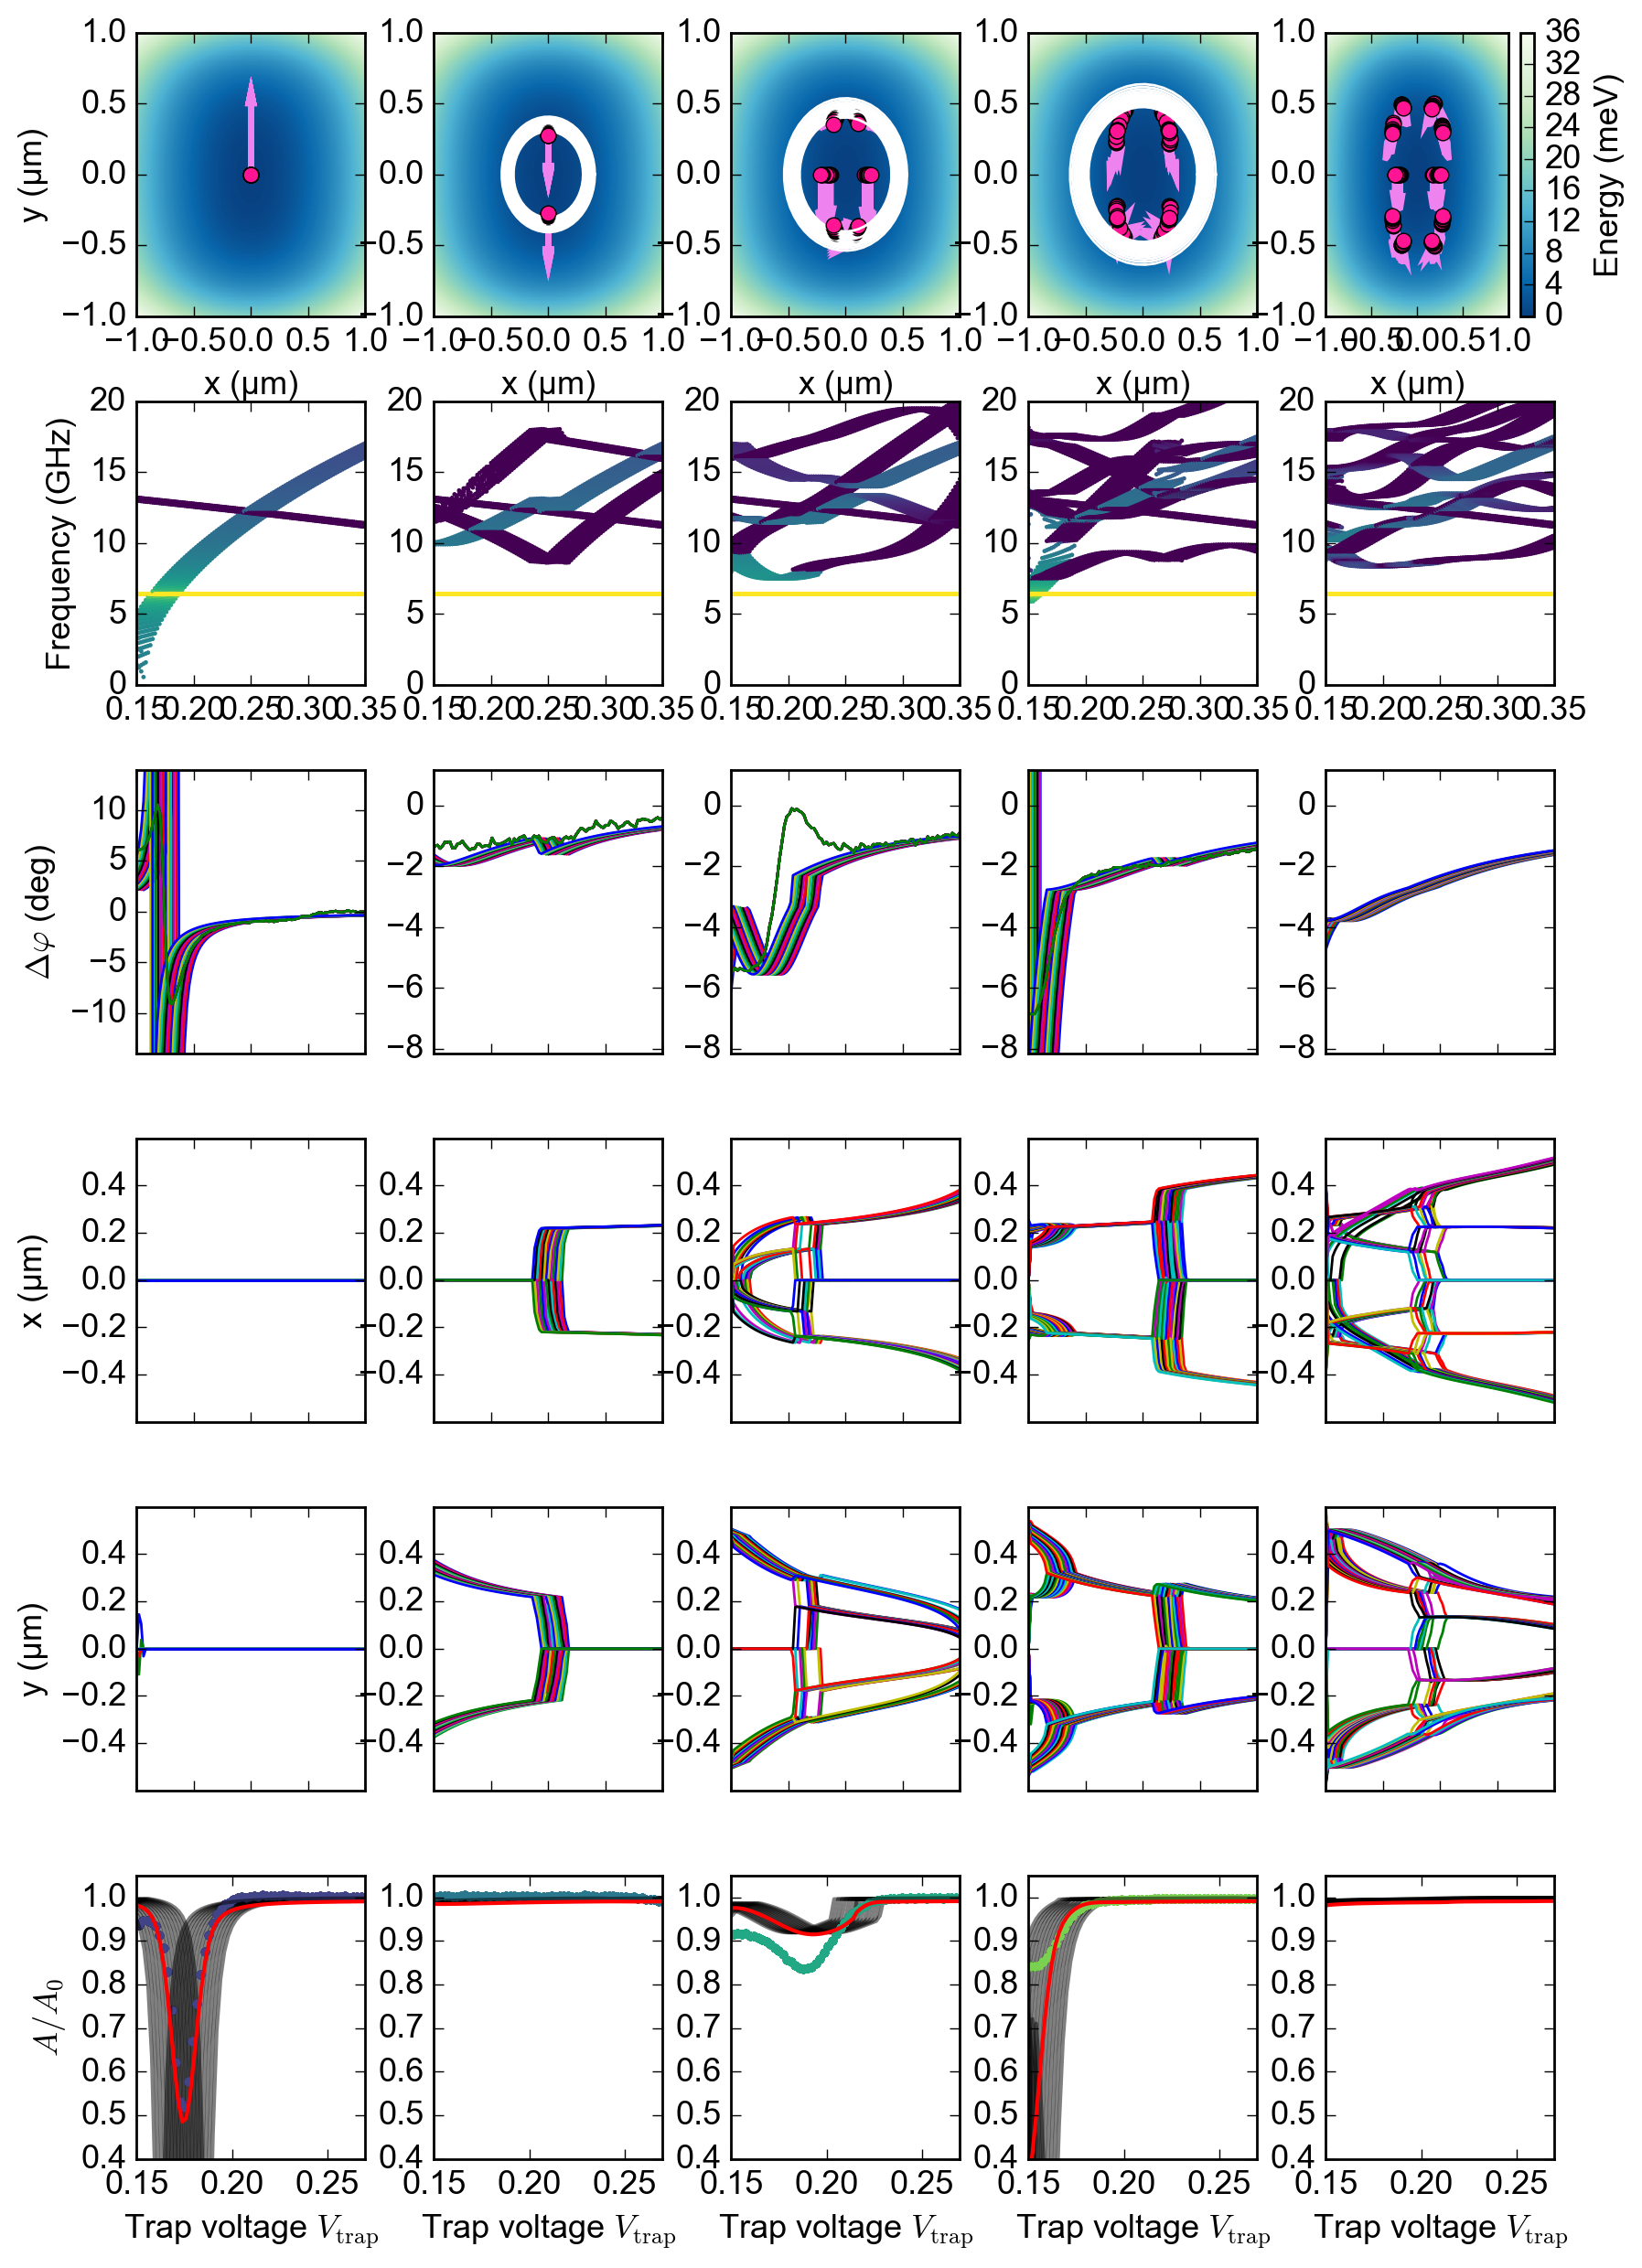

In [50]:
fs.trap_annealing_steps = [0.5] * 10
solve_equations_of_motion = 1
num_columns = 5
Averaging_Points = 15
Vtrap_jitter_sigma = 5E-3
Vtrap_jitter_amp = 12.5E-3

fig2 = plt.figure(figsize=(10, (num_columns+1)*2.5))
common.configure_axes(10)

colors = [plt.cm.viridis(frac) for frac in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]]

from TrapAnalysis import single_electron as se

for N in [1, 2, 3, 4, 5]:
    print("N = ", N)
    for kkk, Voffs in enumerate(np.linspace(-Vtrap_jitter_amp, Vtrap_jitter_amp, Averaging_Points)):
        color = colors[::-1][5 - N]
        use_adaptive_initial_guess = initial_guesses[N-1]["adaptive_guess"]
        electron_initial_positions = initial_guesses[N-1]["init_guess"]

        electrons_in_the_trap = list()
        electron_positions = list(); energies = list()
        EVecs = list(); EVals = list()

        Second_Derivs = np.zeros((len(Vtrap), N, 3))

        for k in trange(len(Vtrap)):
            a_0 = a_0s(Vtrap[k]+Voffs)
            a_1 = a_1s(Vtrap[k]+Voffs)
            a_2 = a_2s(Vtrap[k]+Voffs)
            a_3 = a_3s(Vtrap[k]+Voffs)
            contain_x = contain_xs[k]

            def Phi(xi, yi):
                return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4

            def Phi_x(xi, yi):
                return 2 * a_0 * xi + 3 * a_3 * xi ** 2 + 4 * contain_x * xi ** 3

            def Phi_y(xi, yi):
                return 2 * a_1 * yi + 4 * a_2 * yi ** 3

            def Phi_xx(xi, yi):
                return 2 * a_0 * np.ones(len(xi)) + 6 * a_3 * xi + 12 * contain_x * xi ** 2

            def Phi_xy(xi, yi):
                return np.zeros(len(xi))

            def Phi_yy(xi, yi):
                return 2 * a_1 * np.ones(len(xi)) + 12 * a_2 * yi ** 2

            dummy_x = np.linspace(-2E-6, 2E-6, 501)
            dummy_y = np.linspace(-2E-6, 2E-6, 501)

            CMS = anneal.TrapAreaSolver(dummy_x, dummy_y, np.meshgrid(dummy_x, dummy_y)[0],
                                        spline_order_x=3, spline_order_y=3, smoothing=0,
                                        include_screening=fs.include_screening, screening_length=fs.screening_length)
            CMS.V = Phi

            CMS.dVdx = Phi_x
            CMS.dVdy = Phi_y

            fs.curv_xx = Phi_xx
            fs.curv_xy = Phi_xy
            fs.curv_yy = Phi_yy

            X_eval, Y_eval = np.meshgrid(dummy_x, dummy_y)

            # Solve for the electron positions in the trap area!
            ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                                Uext=CMS.V,
                                                xext=dummy_x, yext=dummy_y, verbose=False, eps=fs.epsilon,
                                                save_path=None)

            ConvMon.figsize = (8., 2.)

            trap_minimizer_options = {'method': 'L-BFGS-B',
                                      'jac': CMS.grad_total,
                                      'options': {'disp': False, 'gtol': fs.gradient_tolerance, 'eps': fs.epsilon},
                                      'callback': None}

            # We save the initial Jacobian of the system for purposes.
            initial_jacobian = CMS.grad_total(electron_initial_positions)
            res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)

            while res['status'] > 0:
                # Try removing unbounded electrons and restart the minimization
                if fs.remove_unbound_electrons:
                    # Remove any electrons that are to the left of the trap
                    best_x, best_y = anneal.r2xy(res['x'])
                    idxs = np.where(np.logical_and(best_x > fs.remove_bounds[0], best_x < fs.remove_bounds[1]))[0]
                    best_x = np.delete(best_x, idxs)
                    best_y = np.delete(best_y, idxs)
                    # Use the solution from the current time step as the initial condition for the next timestep!
                    electron_initial_positions = anneal.xy2r(best_x, best_y)
                    if len(best_x) < len(res['x'][::2]):
                        print("%d/%d unbounded electrons removed. %d electrons remain." % (
                        np.int(len(res['x'][::2]) - len(best_x)), len(res['x'][::2]), len(best_x)))
                    res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)
                else:
                    best_x, best_y = anneal.r2xy(res['x'])
                    idxs = np.union1d(np.where(best_x < -2E-6)[0], np.where(np.abs(best_y) > 2E-6)[0])
                    if len(idxs) > 0:
                        print("Following electrons are outside the simulation domain")
                        for i in idxs:
                            print("(x,y) = (%.3f, %.3f) um" % (best_x[i] * 1E6, best_y[i] * 1E6))
                    # To skip the infinite while loop.
                    break

            if res['status'] > 0:
                cprint("WARNING: Initial minimization for Trap did not converge!", "red")
                print("Final L-inf norm of gradient = %.2f eV/m" % (np.amax(res['jac'])))
                best_res = res
                if k == 0:
                    cprint("Please check your initial condition, are all electrons confined in the simulation area?", "red")
                    break

            if len(fs.trap_annealing_steps) > 0:
                # cprint("SUCCESS: Initial minimization for Trap converged!", "green")
                best_res = CMS.perturb_and_solve(CMS.Vtotal, len(fs.trap_annealing_steps), fs.trap_annealing_steps[0],
                                                 res, maximum_dx=fs.max_x_displacement, maximum_dy=fs.max_y_displacement,
                                                 do_print=False, **trap_minimizer_options)
            else:
                best_res = res

            # Use the solution from the current time step as the initial condition for the next timestep!
            if use_adaptive_initial_guess:
                electron_initial_positions = best_res['x']
            ex, ey = anneal.r2xy(best_res['x'])
            electrons_in_the_trap.append(np.sum(np.logical_and(ex < 1.5E-6,
                                                               ex > 1.5E-6)))

            electron_positions.append(res['x'])
            energies.append(res['fun']) # this will contain the total minimized energy in eV

            if solve_equations_of_motion:
                LHS, RHS = fs.setup_eom(best_res['x'])
                evals, evecs = fs.solve_eom(LHS, RHS)
                EVals.append(evals)
                EVecs.append(evecs)

                Second_Derivs[k, :, 0] = fs.curv_xx(ex, ey)
                Second_Derivs[k, :, 1] = fs.curv_xy(ex, ey)
                Second_Derivs[k, :, 2] = fs.curv_yy(ex, ey)

        electron_positions = np.array(electron_positions)
        energies = np.array(energies)
        EVecs = np.array(EVecs)
        EVals = np.array(EVals)
        Efreqs = np.sqrt(EVals) / (2 * np.pi)

        # Plot the resonator and trap electron configuration at the voltage given by idx
        idx = common.find_nearest(Vtrap, V_crossing)
        trap_electrons_x, trap_electrons_y = anneal.r2xy(electron_positions[idx, :])

        a_0 = a_0s(V_crossing + Voffs)
        a_1 = a_1s(V_crossing + Voffs)
        a_2 = a_2s(V_crossing + Voffs)
        a_3 = a_3s(V_crossing + Voffs)
        contain_x = contain_xs[idx]

        def Phi(xi, yi):
            return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4

        plt.subplot(6, num_columns, N)
        common.configure_axes(13)
        plt.pcolormesh(dummy_x * 1E6, dummy_y * 1E6, Phi(X_eval, Y_eval) * 1E3, cmap=plt.cm.GnBu_r, 
                       vmin=0, vmax=1E3 * Phi(1.0E-6, 1.0E-6))

        # If a_0 == a_1 (radially symmetric) and a_2 = 0, electrons should be on this ring
        theta = np.linspace(0, 2 * np.pi)
        r0 = (2 * q_e ** 2 / (m_e * 4 * np.pi * 8.85E-12 * 2 * q_e * a_1 / m_e)) ** (1 / 3.)

        if N == 2: 
            plt.plot(0.5 * r0 * np.cos(theta) * 1E6, 0.5 * r0 * np.sin(theta) * 1E6, color='white')
        if N == 3: 
            plt.plot(0.66 * r0 * np.cos(theta) * 1E6, 0.66 * r0 * np.sin(theta) * 1E6, color='white')
        if N == 4: 
            plt.plot(0.782 * r0 * np.cos(theta) * 1E6, 0.782 * r0 * np.sin(theta) * 1E6, color='white')

        if best_res['status'] > 0:
            plt.text(0, -2, "Minimization did not converge", fontdict={"size": 10})

        plt.xlabel("x (%sm)"%(chr(956)))
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.plot(trap_electrons_x * 1E6, trap_electrons_y * 1E6, 'o', color='deeppink', alpha=1.0)
        if N == num_columns and kkk == 0:
            cbar = plt.colorbar()
            cbar.ax.set_ylabel("Energy (meV)")
        elif N == 1:
            plt.ylabel("y (%sm)"%(chr(956)))

        plt.subplot(6, num_columns, N + num_columns)

        for i in range(len(Vtrap)):
            sc = plt.scatter([Vtrap[i]]*(2*N + 1), np.sqrt(EVals)[i, :] / (2 * np.pi * 1E9), 
                             c=np.log10(np.abs(EVecs[i, 0, :])), edgecolors='none', cmap=plt.cm.viridis,
                             vmin=0, vmax=4, s=3)


        plt.xlim(np.min(Vtrap), np.max(Vtrap))
        plt.ylim(0, 20)

        if N == 1:
            plt.ylabel('Frequency (GHz)')

        all_ordered_freqs = list()
        strongest_coupled_evecs = list()
        for jj in trange(np.shape(EVecs)[0]):
            cavity_contributions = EVecs[jj, 0, :]
            largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
            all_ordered_freqs.append(np.sqrt(EVals[jj, largest_cavity_contributions])/(2*np.pi*1E9))
            strongest_coupled_evecs.append(EVecs[jj, :, largest_cavity_contributions[1]])

            if jj == idx:
                # Mode #0 is the cavity mode (not interesting)
                mode_nr_1 = largest_cavity_contributions[1]
                # Plot the eigenvectors

        amp = EVecs[idx, 1:, mode_nr_1] / np.sum(np.abs(EVecs[idx, 1:, mode_nr_1])) * 0.5
        plt.subplot(6, num_columns, N)
        for m in range(N):
            plt.arrow(x=electron_positions[idx, ::2][m] * 1E6, y=electron_positions[idx, 1::2][m] * 1E6, dx=amp[m], 
                      dy=amp[N+m] * 1, head_width=0.05, head_length=0.10, fc='violet', ec='violet', lw=2)

        all_ordered_freqs = np.array(all_ordered_freqs)
        strongest_coupled_evecs = np.array(strongest_coupled_evecs)

        # Calculate the coupling
        if N == 1:
            g_test = common.find_nearest(Vtrap, 0.20)
            all_ordered_freqs[g_test, 0]
            cav_freq_shift = np.abs(all_ordered_freqs[g_test, 0] * 1E9 - fs.resonator_constants['f0'])
            detuning = np.abs(all_ordered_freqs[g_test, 0] - all_ordered_freqs[g_test, 1]) * 1E9

    #         print("The average coupling from the EOM is g = ", 1E-6 * np.sqrt(cav_freq_shift * detuning / N), " MHz")

        plt.subplot(6, num_columns, N + 2*num_columns)
        plt.plot(Vtrap, 180. / (np.pi * kappa_tot) * (all_ordered_freqs[:, 0] * 1E9 - fs.resonator_constants['f0']))
        plt.xlim(np.min(Vtrap), np.max(Vtrap))
        plt.gca().set_xticklabels([])

        try: 
            plt.plot(Vtrap_experiment, vars()['phases_experiment_%d'%N] + phase_offsets[N-1])
        except:
            pass

        if N == 1:
    #         plt.ylabel(r'$\Delta f_0$ (MHz)')
            plt.ylabel(r'$\Delta \varphi$ (deg)')
            plt.ylim(-0.12E6 * 180/(np.pi * kappa_tot), 0.12E6 * 180/(np.pi * kappa_tot))
        else:
            plt.ylim(-0.07E6 * 180/(np.pi * kappa_tot), 0.01E6 * 180/(np.pi * kappa_tot))

        plt.subplot(6, num_columns, N + 3 * num_columns)
        for n in range(N):
            plt.plot(Vtrap, electron_positions[:, 2*n] * 1E6)
        plt.xlim(np.min(Vtrap), np.max(Vtrap))
        plt.ylim(-0.6, 0.6)
        plt.gca().set_xticklabels([])

        if N == 1:
            plt.ylabel('x (%sm)'%(chr(956)))

        plt.subplot(6, num_columns, N + 4 * num_columns)
        for n in range(N):
            plt.plot(Vtrap, electron_positions[:, 1 + 2*n] * 1E6)
        plt.xlim(np.min(Vtrap), np.max(Vtrap))
        plt.ylim(-0.6, 0.6)
        plt.gca().set_xticklabels([])

        if N == 1:
            plt.ylabel('y (%sm)'%(chr(956)))

        electron_modes_to_consider = [1] #[1, 2, 3, 4] # Note: 0 is the cavity mode
        kappa_tot = fs.resonator_constants['f0'] / fs.resonator_constants['Q']
        f_probe = fs.resonator_constants['f0']
        f_cavity = fs.resonator_constants['f0']

        # mag_signal, phase_signal = list(), list()
        chi = np.zeros(len(Vtrap), dtype=np.complex128)
        for i, g in enumerate(Vtrap):
            for mode in electron_modes_to_consider:
                chi[i] += se.susceptibility(9E6, f_probe, all_ordered_freqs[i, mode] * 1E9, 0E6)

        single_response = 2 * np.pi * (kappa_tot / 2.) / (2 * np.pi * (f_probe - f_cavity) - chi + 1j * 2 * np.pi * (kappa_tot / 2.))
        mag_signal = 20 * np.log10(np.abs(single_response))
        phase_signal = 180 / np.pi * (np.arctan2(-np.imag(single_response), np.real(single_response)) - np.pi/2.)    

        plt.subplot(6, num_columns, N + 5 * num_columns)
        try: 
            plt.plot(Vtrap_experiment, vars()['mags_experiment_%d'%N], '.', color=color, lw=2, label='Experiment')
        except:
            pass
        
        plt.plot(Vtrap, 10 ** (mag_signal / 10.), '-', color='k', ms=2, lw=1.5, label='Model', alpha=0.5)
        plt.ylim(0.40, 1.05)
        plt.xlim(np.min(Vtrap), 0.27)
        plt.xticks([0.15, 0.20, 0.25])
        if N == 1:
            plt.ylabel("$A/A_0$")

        plt.xlabel('Trap voltage $V_\mathrm{trap}$')
        
        def weight(V, Mean, Std):
            return 1 / np.sqrt(2 * np.pi * Std ** 2) * np.exp(- (V - Mean) ** 2 / (2 * Std ** 2))
        
        # Normalize the weights
        current_weight = (2 * Vtrap_jitter_amp) / (Averaging_Points-1) * weight(Voffs, 0, Vtrap_jitter_sigma)
        if kkk == 0:
            averaged_lin_mag = np.abs(single_response) ** 2 * current_weight
        else:
            averaged_lin_mag += np.abs(single_response) ** 2 * current_weight
    
    vars()["Positions_%d"%N] = electron_positions
    vars()["Simulated_Magnitude_%d"%N] = 10 ** (mag_signal / 10.)
    vars()["Simulated_Phase_%d"%N] = phase_signal
    vars()["All_Frequencies_%d"%N] = all_ordered_freqs
    vars()["All_Eigenvectors_%d"%N] = strongest_coupled_evecs
    
    plt.subplot(6, num_columns, N + 5 * num_columns)
    plt.plot(Vtrap, averaged_lin_mag, color='r', lw=1.5)
    
plt.subplots_adjust(wspace=0.30, hspace=0.30)
# fig2.tight_layout()

Let's make sure that the weights sum to unity.

The sum of the weights is 0.992915699495


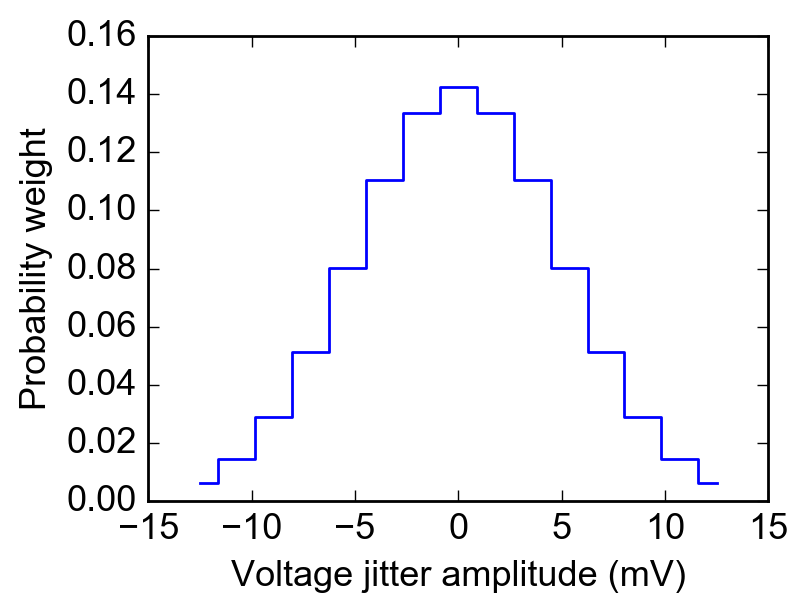

In [61]:
V = np.linspace(-Vtrap_jitter_amp, Vtrap_jitter_amp, Averaging_Points)
curr_weight = (2 * Vtrap_jitter_amp) / (Averaging_Points-1) * weight(V, 0, Vtrap_jitter_sigma)

fig = plt.figure(figsize=(4.,3.))
common.configure_axes(13)
# plt.plot(V, curr_weight, 'o')
plt.step(V * 1e3, curr_weight, where='mid')
plt.xlabel("Voltage jitter amplitude (mV)")
plt.ylabel("Probability weight")

print("The sum of the weights is", np.sum(curr_weight))

Let us calculate the predicted linewidth $$\gamma_\varphi = 2 \sqrt{2 \ln 2} \, \partial f_e / \partial V_\mathrm{trap} \, \sigma_{V_\mathrm{trap}}$$

In [60]:
df_dV = 95E9 #Hz/V
2 * np.sqrt(2 * np.log(2)) * df_dV * Vtrap_jitter_sigma / 1e6

1118.5395213897009

The linewidth that follows from the assumptions:

- The entire linewidth is dominated by fluctuations in voltage.
- Each individual interaction between the interaction and the resonator can be modeled as if $\gamma = 0$.

is much too big (~ 1 GHz) compared with the measured linewidth (~70 MHz). Equivalently, the voltage fluctuations that explain the measured traces (~5 mV) are much larger than the voltage fluctuations measured when monitoring the crossing voltage as function of time (~0.3 mV). Therefore, these assumptions cannot be right. Maybe a smaller voltage fluctuation in combination with a residual $\gamma$ can model the experimental results better.